In [97]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

In [128]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)
working_dir = 'C:/users/breeves/source/repos/tsforecast'
#start in the 60s for convenience
START_DATE = pd.Timestamp('1960-01-01')

Populating the interactive namespace from numpy and matplotlib


In [129]:
y = pd.read_csv(path.join(working_dir, 'US_GDP.csv'), squeeze=True, index_col=['date'], parse_dates=True)
y = y.rename('gdp').loc[START_DATE:]
df = pd.read_csv(path.join(working_dir, 'US_macro.csv'), squeeze=True, 
                 index_col=['date'], parse_dates=True).loc[START_DATE:]
df_norm = df.ffill().asfreq('Q').apply(lambda x: (x - x.mean())/ x.std())
df_XY = pd.concat([df_norm, y], axis=1)

In [130]:
#Get start date for each indicator
df.apply(lambda x: min(x.dropna().index)).rename('data_start_date').to_frame()

,data_start_date
credit_impulse,1960-03-31
fix,1971-01-08
unemployment_claims,1967-01-06
building_permits,1960-01-31
housing_starts,1960-12-31
yc_30_10,1977-02-15
yc_10_2,1976-06-01
lei,1960-01-31
hy_spread,1987-03-31


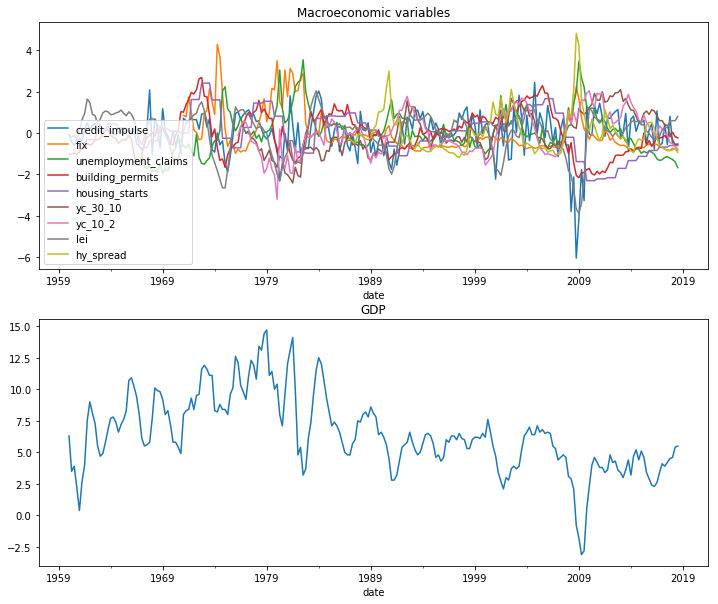

In [116]:
df_norm.plot(ax=plt.subplot(211))
plt.title('Macroeconomic variables')
y.plot(ax=plt.subplot(212))
plt.title('GDP');

## About the macro dataset:
All data has already been seasonally adjusted 

- GDP: YOY change in GDP (%), not adjusted for inflation (quarterly data)
- credit_impulse: change in new credit issued as a % of GDP. In most countries, private sector demand correlates closely with credit impulse
- fix: Financial conditions index. How easily is money flowing in the financial world 
- unemployment_claims: how many people are filing unemployment claims
- building_permits: how many new construction permits have been issued by the gov't
- housing_starts: how many residential units have begun construction
- yc_30_10: difference between the 30 year and 10 year US government bond yields . The [yield curve](https://www.investopedia.com/terms/y/yieldcurve.asp) is a measure of interest rates and how cheap or expensive it is to borrow (lend) money
- yc_10_2: difference between the 10 and 2 year government bond yields
- lei: Leading economic indicators. Index compiled by independent researchers comprised of various factors which should lead the economy
- hy_spread: difference between the yield on junk bonds and government bonds. When this is low, people are willing to take more risk and lend to less-trustworthy institutions. When this is high, people are less willing to lend


In [117]:
def heatmap(df, subtitle=None):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = df.corr()
    hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                     linewidths=.05)
    f.subplots_adjust(top=0.93)
    if subtitle is not None:
        t= f.suptitle(subtitle, fontsize=14)
    else:
         t= f.suptitle('Correlation Heatmap', fontsize=14)

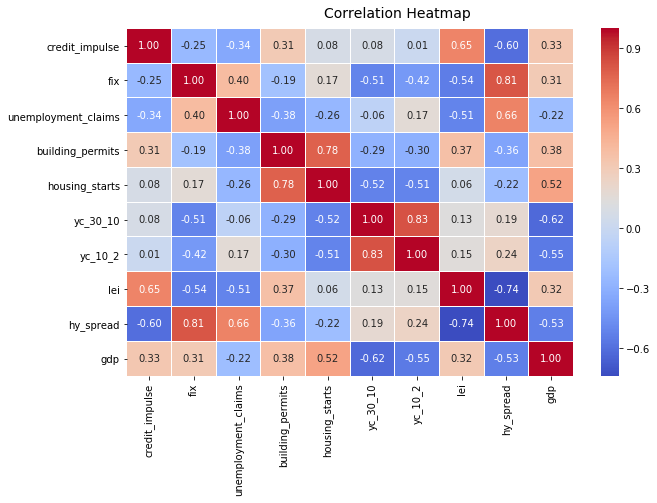

In [118]:
heatmap(df_XY)

### Check autocorrelation and pacf of our series 
Good summary can be found [here](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) 
Autocorrelation is correlation of a series with itself. pacf is the same, but with the effects of intervening observations removed

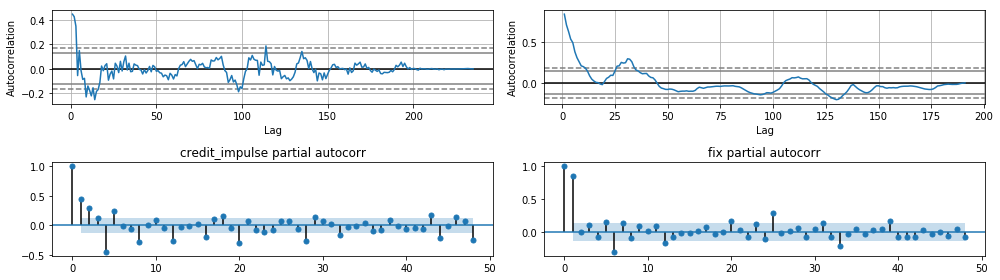

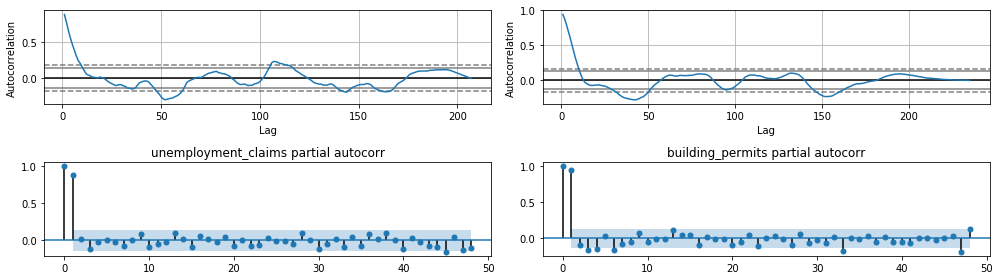

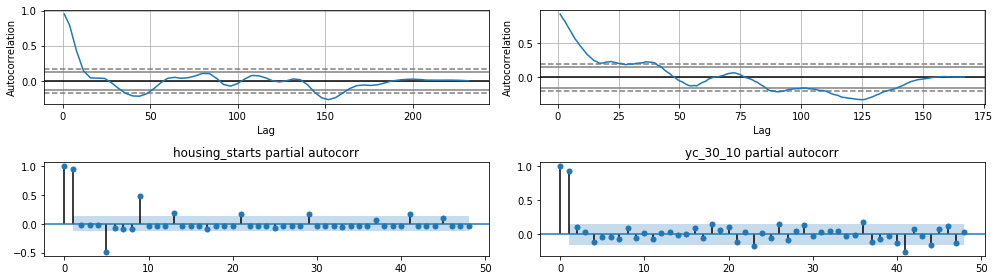

C:\Users\breeves\AppData\Local\Continuum\miniconda3\envs\py3default\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


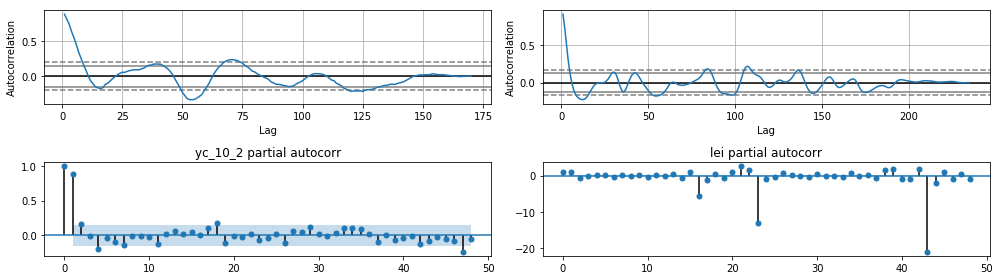

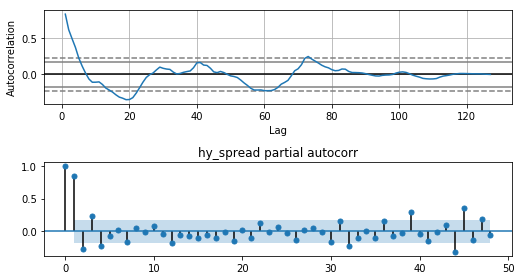

In [119]:
pylab.rcParams['figure.figsize'] = (14, 4)

for i, col in enumerate(df_norm.columns):
    ax = plt.subplot(221) if i % 2 == 0 else plt.subplot(222)
    ax2 = plt.subplot(223) if i % 2 == 0 else plt.subplot(224)
    s = df_norm[col].dropna()
    autocorrelation_plot(s, ax=ax)
    plt.title(f'{col} autocorr')
    plot_pacf(s, lags=48, ax=ax2)
    plt.title(f'{col} partial autocorr')
    if i % 2 != 0 or i == len(df_norm.columns) - 1:
        plt.tight_layout()
        plt.show()
        
        
pylab.rcParams['figure.figsize'] = (12, 10)


### Check for stationarity

- if using autoregressive model (eg VAR), all series [must be stationary](https://www.researchgate.net/post/Is_it_necessary_to_ensure_stationarity_of_all_time_series_variables_when_you_run_a_Vector_Autoregressive_VAR_Model) unless corrected for coeintegration
- Reference with example code https://machinelearningmastery.com/time-series-data-stationary-python/

Interestingly, I expected the raw GDP data to be stationary, since the source data has already been differenced once (t(i) - t(i-4)) to achieve the YOY change. That initial thought was incorrect - the rate of change of GDP in the US has not been stationary

In [120]:
def display_adf(series):
    result = adf(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))   

In [121]:
print('---------------------------')  
print('Original')    
print('---------------------------')  
result = display_adf(y)
print('---------------------------')  
print('Since 1980')    
print('---------------------------')  
result = display_adf(y.loc['1980-01-01':])
print('---------------------------')    
print('Differenced')    
print('---------------------------')  
result = display_adf(y.diff().dropna())

---------------------------
Original
---------------------------
ADF Statistic: -1.536648
p-value: 0.515310
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
---------------------------
Since 1980
---------------------------
ADF Statistic: -1.918847
p-value: 0.323248
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
---------------------------
Differenced
---------------------------
ADF Statistic: -5.916534
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


## Things to try:

- Determine what type of model you want to try. For beginners, I'd recommend a simple sklearn regression algo with some feature engineering to try and approximate a markov process. More advanced users may want to experiment with VARs or even LSTMs if they're feeling particularly inspired
 - [VAR reference ](https://www.statsmodels.org/dev/vector_ar.html)
 - [ARIMA ref](http://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html)
 - [LSTM ref](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)
- If necessary, transform any non-stationary series into stationary series
- I'll sometimes impute missing data going back a little ways in time so that I don't have to drop huge amounts of data. If you have time, try experimenting with using longer term data, dropping different external variables or imputing them
 - [MICE](https://www.statsmodels.org/dev/generated/statsmodels.imputation.mice.MICE.html#statsmodels.imputation.mice.MICE)
 - [fancyimpute](https://pypi.org/project/fancyimpute/)
- Perform some feature engineering, especially if you're using a model that is not time series aware (eg regression models). You can create moving averages, derivatives, statistical moment arms, lagged variables, percent changes over time, etc.
- Try running a model if you have time!
 